In [3]:
import pathlib
from src.models.cmu_mosei_module import CmuMoseiModule
import torch

notebook_folder = pathlib.Path().resolve()
project_folder = notebook_folder.parent
data_folder = project_folder / "best_models" / "best_audio_model.ckpt"
test_text_model_checkpoint = str(data_folder)

device = torch.device("cpu" if torch.cpu.is_available() else "mps")
model = CmuMoseiModule.load_from_checkpoint(test_text_model_checkpoint).to(device)
model.eval()

CmuMoseiModule(
  (model): EmotionClassifier(
    (embedding_creator): AudioVideoEmotionEmbeddingCreator(
      (cnn): Sequential(
        (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Sigmoid()
        (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): Sigmoid()
        (4): AdaptiveMaxPool1d(output_size=1)
      )
      (lstm): LSTM(64, 256, batch_first=True)
    )
    (classifier): Classifier(
      (fc): Sequential(
        (0): Dropout(p=0.3, inplace=False)
        (1): Linear(in_features=256, out_features=128, bias=True)
        (2): Sigmoid()
        (3): Linear(in_features=128, out_features=7, bias=True)
      )
    )
  )
  (criterion): CrossEntropyLoss()
  (train_acc): MulticlassAccuracy()
  (val_acc): MulticlassAccuracy()
  (test_acc): MulticlassAccuracy()
  (val_acc_best): MaxMetric()
  (val_f1_best): MaxMetric()
  (val_confmat_best): MaxMetric()
  (val_f1): MulticlassF1Score()
  (val_confmat): MulticlassConfusionMatr

In [8]:
import torch

notebook_folder = pathlib.Path().resolve()
project_folder = notebook_folder.parent
data_folder = project_folder / "data" / "aligned_covarep_data"
test_data_file = data_folder / "test_data.pkl"
test_labels_file = data_folder / "test_labels.pkl"
with open(test_data_file, "rb") as f:
    audio_test_features = torch.load(f)
with open(test_labels_file, "rb") as f:
    audio_test_labels = torch.load(f)

In [9]:
from src.data.components.video_and_audio_dataset import AudioAndVideoDataset
from torch.utils.data import DataLoader

test_dataset = AudioAndVideoDataset(features_list=audio_test_features, labels_list=audio_test_labels)
test_loader = DataLoader(test_dataset, batch_size=64)

In [10]:
all_test_predictions = []
all_test_labels = []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        _, predictions, labels = model.model_step(batch)
        all_test_predictions.extend(predictions.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

<Figure size 800x600 with 0 Axes>

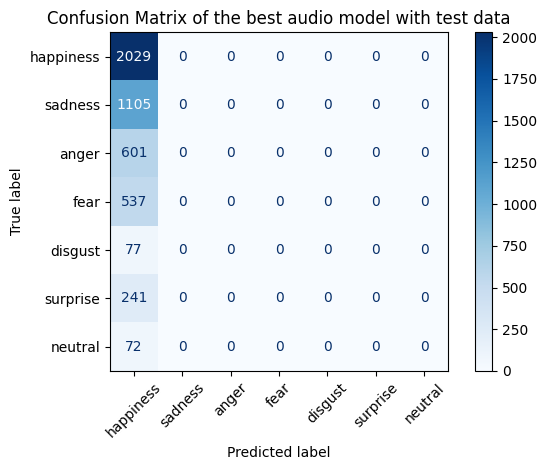

In [11]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_names = ["happiness", "sadness", "anger", "fear", "disgust", "surprise", "neutral"]

cm = confusion_matrix(all_test_labels, all_test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix of the best audio model with test data")
plt.grid(False)
plt.tight_layout()
plt.show()